In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from sklearn.preprocessing import PowerTransformer


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Funções de suporte




In [ ]:
def check_stationarity(series: pd.Series, seasonal_period: int = None, alpha: float = 0.05):
    """
    Check stationarity of a time series using the Augmented Dickey-Fuller test.
    Optionally handle seasonal differencing.

    Parameters:
        series (pd.Series): The input time series.
        seasonal_period (int, optional): Seasonal period (e.g., 12 for monthly).
        alpha (float): Significance level for ADF test.

    Returns:
        dict: {
            'adf_stat': float,
            'p_value': float,
            'stationary': bool,
            'diffs_needed': int,
            'seasonal_diffs_needed': int
        }
    """
    def is_stationary(y):
        result = adfuller(y, autolag='AIC')
        return result[0], result[1], result[1] < alpha

    y = series.dropna()
    if isinstance(series, pd.DataFrame):
        y = series.iloc[:, 0]

    # Check original series
    adf_stat, p_val, stationary = is_stationary(y)
    if stationary:
        return {
            'adf_stat': adf_stat,
            'p_value': p_val,
            'stationary': True,
            'diffs_needed': 0,
            'seasonal_diffs_needed': 0
        }

    # Seasonal differencing
    seasonal_diffs = 0
    if seasonal_period:
        for s in range(1, 3):  # try 1 or 2 seasonal diffs
            y_seasonal = y.diff(seasonal_period * s).dropna()
            adf_stat, p_val, stationary = is_stationary(y_seasonal)
            if stationary:
                return {
                    'adf_stat': adf_stat,
                    'p_value': p_val,
                    'stationary': True,
                    'diffs_needed': 0,
                    'seasonal_diffs_needed': s
                }

    # Try both seasonal + regular differencing
    if seasonal_period:
        y_combo = y.copy()
        for s in range(1, 3):
            for d in range(1, 3):
                y_combo = y.diff(seasonal_period * s).dropna().diff(d).dropna()
                adf_stat, p_val, stationary = is_stationary(y_combo)
                if stationary:
                    return {
                        'adf_stat': adf_stat,
                        'p_value': p_val,
                        'stationary': True,
                        'diffs_needed': d,
                        'seasonal_diffs_needed': s
                    }

    # Regular differencing
    diffs = 0
    y_diff = y.copy()
    while diffs < 3:
        y_diff = y_diff.diff().dropna()
        adf_stat, p_val, stationary = is_stationary(y_diff)
        diffs += 1
        if stationary:
            return {
                'adf_stat': adf_stat,
                'p_value': p_val,
                'stationary': True,
                'diffs_needed': diffs,
                'seasonal_diffs_needed': 0
            }


    # If nothing worked
    return {
        'adf_stat': adf_stat,
        'p_value': p_val,
        'stationary': False,
        'diffs_needed': diffs,
        'seasonal_diffs_needed': seasonal_diffs
    }


In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from multiprocessing import Pool, cpu_count
from typing import Union
from tqdm.notebook import tqdm

# Define your function to run in parallel
def fit_sarima(args):
    endog, order, d, D, s, seasonal = args
    try:
          model = SARIMAX(
              endog,
              order=(order[0], d, order[1]),
              seasonal_order=(order[2], D, order[3], s),
              simple_differencing=False
          ).fit(disp=False)
          return (order, model.aic)
    except:
        return None

def optimize_SARIMA_parallel(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    args_list = [(endog, order, d, D, s) for order in order_list]
    print(cpu_count())
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(fit_sarima, args_list), total=len(order_list)))

    # Filter out failed attempts (None)
    results = [res for res in results if res is not None]

    result_df = pd.DataFrame(results, columns=['(p,q,P,Q)', 'AIC'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
import numpy as np

def check_white_noise(residuals: pd.Series, lags: int = 20, alpha: float = 0.05):
    """
    Check if residuals and squared residuals are white noise using the Ljung-Box test.

    Parameters:
        residuals (pd.Series): Residuals from a model.
        lags (int): Number of lags to test.
        alpha (float): Significance level.

    Returns:
        dict: {
            'residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            },
            'squared_residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            }
        }
    """
    # Drop NaNs just in case
    residuals = pd.Series(residuals).dropna()
    squared_residuals = residuals**2

    # Ljung-Box on residuals
    lb_resid = acorr_ljungbox(residuals, lags=lags, return_df=True)
    resid_pvals = lb_resid['lb_pvalue']
    resid_failed = (resid_pvals < alpha).sum()

    # Ljung-Box on squared residuals
    lb_sq = acorr_ljungbox(squared_residuals, lags=lags, return_df=True)
    sq_pvals = lb_sq['lb_pvalue']
    sq_failed = (sq_pvals < alpha).sum()

    return {
        'residuals': {
            'p_values': resid_pvals,
            'lags_failed': resid_failed
        },
        'squared_residuals': {
            'p_values': sq_pvals,
            'lags_failed': sq_failed
        }
    }


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_model_mape(test_df, actual_col, pred_cols, title="Model Comparison (MAPE %)"):
    """
    Plots a bar chart of MAPE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    mape_scores = [mape(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, mape_scores, width=0.6,  edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('MAPE (%)')
    ax.set_ylim(0, max(mape_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(mape_scores):
        ax.text(i, val + 0.5, f"{val:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, mape_scores))


In [ ]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_model_rmse(test_df, actual_col, pred_cols, title="Model Comparison (RMSE)"):
    """
    Plots a bar chart of RMSE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    rmse_scores = [rmse(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, rmse_scores, width=0.6, color='lightcoral', edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('RMSE')
    ax.set_ylim(0, max(rmse_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(rmse_scores):
        ax.text(i, val + max(rmse_scores) * 0.03, f"{val:.4f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, rmse_scores))


# SELEÇÃO DE MODELO


## Carregamento e visualização inicial da série

In [ ]:
df = pd.read_excel('/content/DadosCompeticao.xlsx', decimal=',')
serie_6 = df.iloc[:, 5]
serie_6.head()

,#6
0,0.828375
1,0.931596
2,0.910756
3,0.853162
4,0.810279


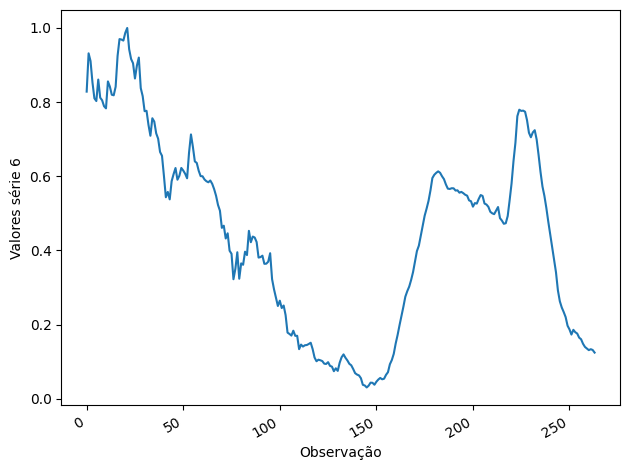

In [ ]:
fig, ax = plt.subplots()

ax.plot(serie_6)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores série 6')

fig.autofmt_xdate()
plt.tight_layout()


## Busca por sinais de sazonalidade

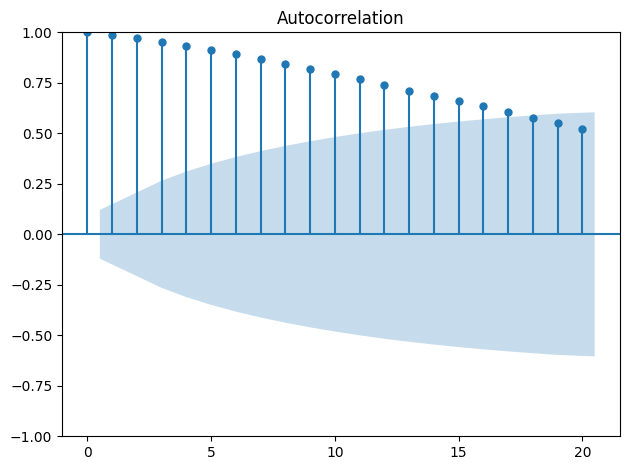

In [ ]:
plot_acf(serie_6, lags=20);
plt.tight_layout()

In [ ]:
advanced_decomposition = STL(serie_6,period=12).fit()

## Conjunto de treino

In [ ]:
test = pd.DataFrame()
test["Values"] = serie_6.iloc[-12:]
test['naive_seasonal'] = serie_6.iloc[-24:-12].values
test['naive_seasonal-A'] = serie_6.iloc[-24:-12].mean()

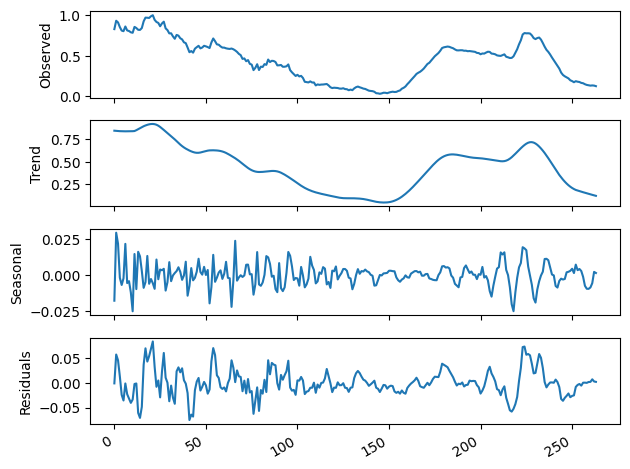

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

## SARIMA

In [ ]:
check_stationarity(serie_6,seasonal_period=12)

{'adf_stat': np.float64(-7.3853209980967005),
 'p_value': np.float64(8.266137196514707e-11),
 'stationary': True,
 'diffs_needed': 1,
 'seasonal_diffs_needed': 1}

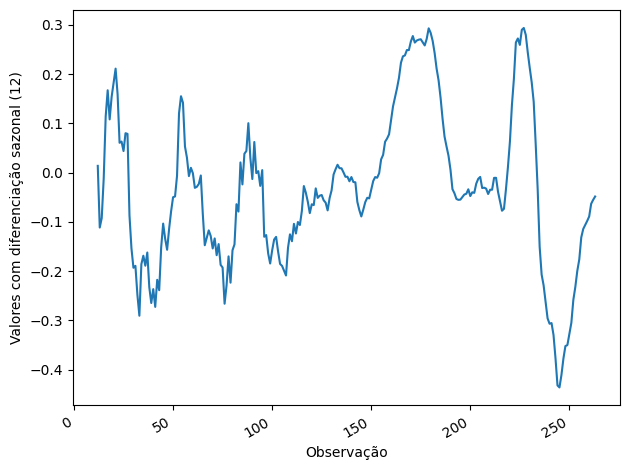

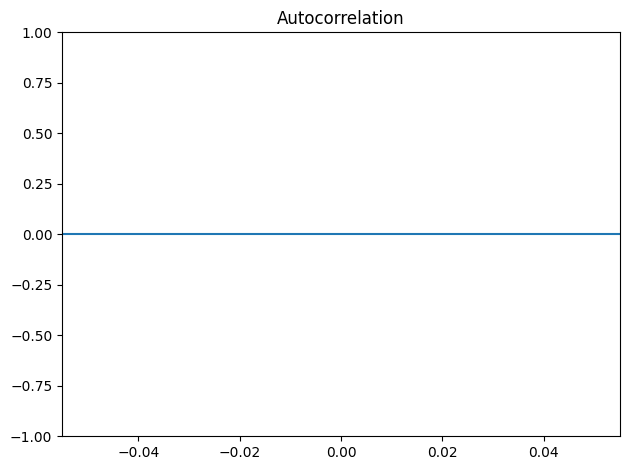

In [ ]:
seasonal_diff = serie_6.diff(12)
fig, ax = plt.subplots()

ax.plot(seasonal_diff)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores com diferenciação sazonal (12)')

fig.autofmt_xdate()
plt.tight_layout()
plot_acf(seasonal_diff, lags=24);
plt.tight_layout()

### Treinamento

In [ ]:
train = serie_6[:-12]
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)


```
 from itertools import product

 ps = range(0, 5)
 qs = range(0, 5)
 Ps = range(0, 5)
 Qs = range(0, 5)

 SARIMA_order_list = list(product(ps, qs, Ps, Qs))

 train = serie_1[:-12]

 d = 1
 D = 0
 s = 12

 SARIMA_result_df = optimize_SARIMA_parallel(train, SARIMA_order_list, d, D, s)
 SARIMA_result_df
 */

```
Modelos selecionados:  \\

* ARIMA(0,1,11) | AIC = -1557.544179 \\
* SARIMA(1,1,0)(0,1,2,12) | AIC = -1091.967980


In [ ]:
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)

ARIMA_model = SARIMAX(train_transformed, order=(4,2,4), seasonal_order=(0,0,0,0), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)


SARIMA_model = SARIMAX(train_transformed, order=(1,1,0), seasonal_order=(0,1,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

In [ ]:
forecast_ARIMA = ARIMA_model_fit.forecast(steps=12)
test['ARIMA_pred'] = pt.inverse_transform(forecast_ARIMA.values.reshape(-1, 1)).flatten()
forecast_SARIMA = SARIMA_model_fit.forecast(steps=12)
test['SARIMA_pred'] = pt.inverse_transform(forecast_SARIMA.values.reshape(-1, 1)).flatten()


In [ ]:
test

,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred
252,0.186094,0.444688,0.282264,0.159321,0.170935
253,0.179685,0.412023,0.282264,0.143595,0.173996
254,0.176004,0.375615,0.282264,0.130461,0.178110
255,0.165046,0.341323,0.282264,0.116214,0.190802
256,0.160674,0.292300,0.282264,0.103438,0.201172
257,0.148492,0.262923,0.282264,0.088449,0.212692
258,0.140049,0.246220,0.282264,0.074835,0.223138
259,0.135862,0.234041,0.282264,0.059815,0.227119
260,0.131318,0.220426,0.282264,0.046798,0.229877
261,0.133851,0.197167,0.282264,0.032377,0.237413


### Análise de resíduos

In [ ]:
check_white_noise(ARIMA_model_fit.resid, lags = 24)

{'residuals': {'p_values': 1     0.000241
  2     0.000869
  3     0.001618
  4     0.003265
  5     0.007296
  6     0.008312
  7     0.014817
  8     0.025252
  9     0.040776
  10    0.058135
  11    0.054264
  12    0.070377
  13    0.098981
  14    0.125196
  15    0.164737
  16    0.195412
  17    0.242130
  18    0.294055
  19    0.348908
  20    0.405012
  21    0.466968
  22    0.465894
  23    0.523669
  24    0.581904
  Name: lb_pvalue, dtype: float64,
  'lags_failed': np.int64(9)},
 'squared_residuals': {'p_values': 1     0.020022
  2     0.063551
  3     0.136631
  4     0.236637
  5     0.354082
  6     0.476170
  7     0.593799
  8     0.698072
  9     0.784470
  10    0.851948
  11    0.901463
  12    0.936916
  13    0.960910
  14    0.976519
  15    0.986310
  16    0.992179
  17    0.995681
  18    0.997675
  19    0.998778
  20    0.999373
  21    0.999685
  22    0.999845
  23    0.999925
  24    0.999965
  Name: lb_pvalue, dtype: float64,
  'lags_failed': np.int64

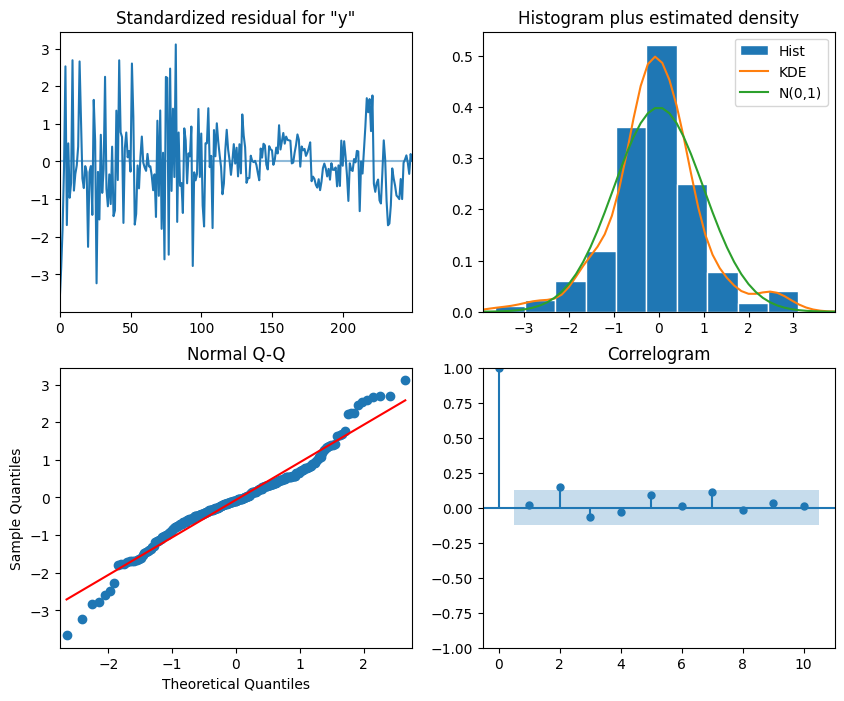

In [ ]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [ ]:
check_white_noise(SARIMA_model_fit.resid, lags = 12)

{'residuals': {'p_values': 1     0.233974
  2     0.446851
  3     0.460244
  4     0.520385
  5     0.449096
  6     0.550450
  7     0.611771
  8     0.714328
  9     0.797356
  10    0.750061
  11    0.766930
  12    0.000340
  Name: lb_pvalue, dtype: float64,
  'lags_failed': np.int64(1)},
 'squared_residuals': {'p_values': 1     0.789196
  2     0.964802
  3     0.994723
  4     0.999299
  5     0.999916
  6     0.999989
  7     0.999999
  8     1.000000
  9     1.000000
  10    1.000000
  11    1.000000
  12    0.169419
  Name: lb_pvalue, dtype: float64,
  'lags_failed': np.int64(0)}}

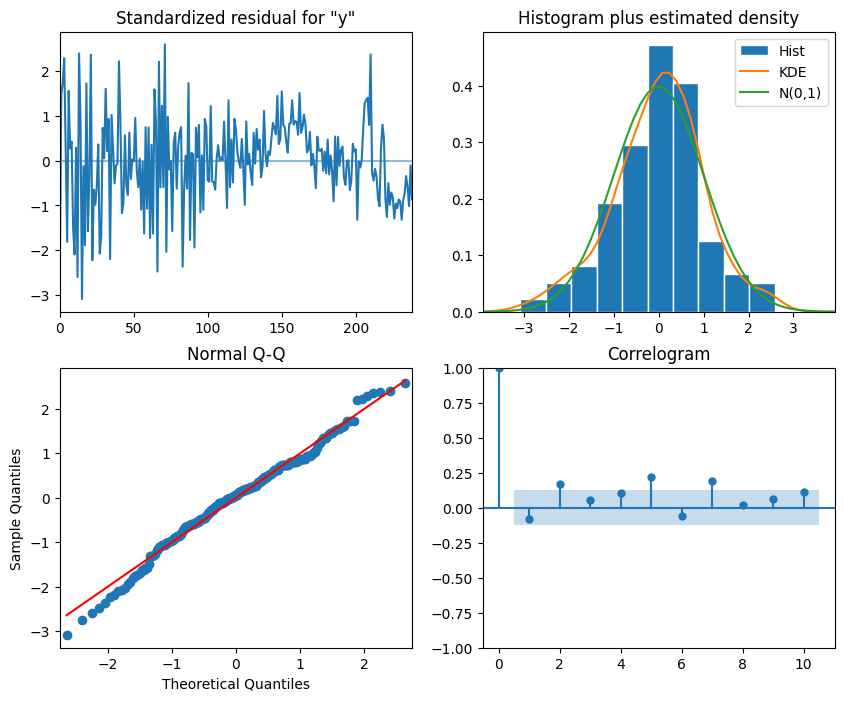

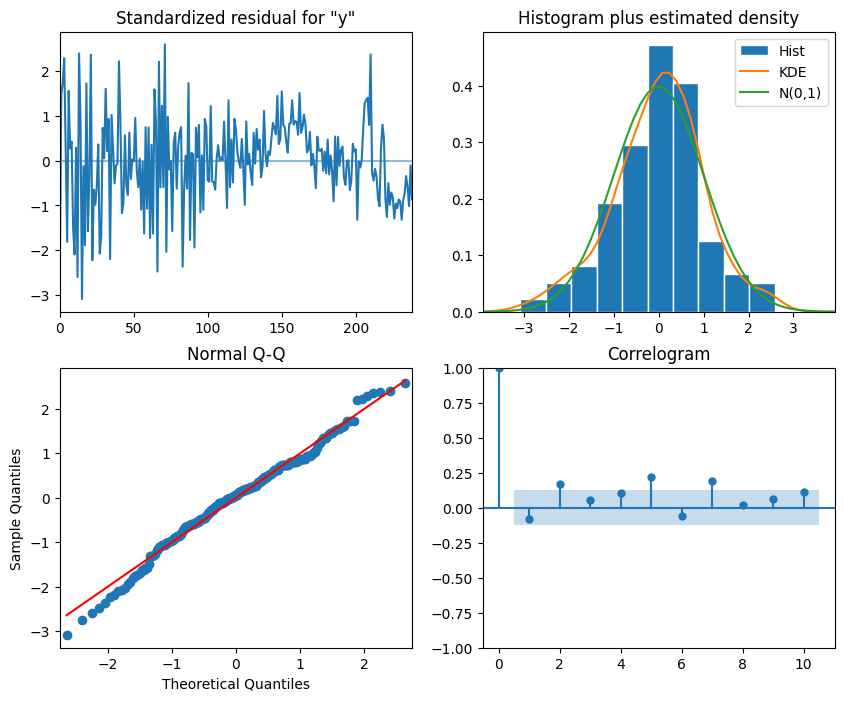

In [ ]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

## Holt-Winters

### Treinamento

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import PowerTransformer
import pandas as pd
import numpy as np

train = serie_6[:-12]
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)
ES = ExponentialSmoothing(train_transformed,trend='add', damped_trend=True)
ES_fit = ES.fit()
forecast_1 =  pt.inverse_transform(ES_fit.forecast(12).values.reshape(-1, 1)).flatten()

ES3 = ExponentialSmoothing(train, trend='add')
ES3_fit = ES3.fit()

test["HW"] = forecast_1
test["HW_P"] = ES3_fit.forecast(12).values
test


,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred,HW,HW_P
252,0.186094,0.444688,0.282264,0.159321,0.170935,0.165517,0.152823
253,0.179685,0.412023,0.282264,0.143595,0.173996,0.159258,0.132349
254,0.176004,0.375615,0.282264,0.130461,0.178110,0.154256,0.111874
255,0.165046,0.341323,0.282264,0.116214,0.190802,0.150257,0.091399
256,0.160674,0.292300,0.282264,0.103438,0.201172,0.147060,0.070925
257,0.148492,0.262923,0.282264,0.088449,0.212692,0.144504,0.050450
258,0.140049,0.246220,0.282264,0.074835,0.223138,0.142459,0.029975
259,0.135862,0.234041,0.282264,0.059815,0.227119,0.140825,0.009501
260,0.131318,0.220426,0.282264,0.046798,0.229877,0.139517,-0.010974
261,0.133851,0.197167,0.282264,0.032377,0.237413,0.138471,-0.031449


In [ ]:
print("Residuos 1:" + str(check_white_noise(ES_fit.resid)))

Residuos 1:{'residuals': {'p_values': 1     0.951735
2     0.995220
3     0.736276
4     0.765066
5     0.236250
6     0.262533
7     0.358587
8     0.382250
9     0.284570
10    0.105312
11    0.095411
12    0.003974
13    0.004780
14    0.002992
15    0.001608
16    0.002314
17    0.002164
18    0.001425
19    0.002168
20    0.001513
Name: lb_pvalue, dtype: float64, 'lags_failed': np.int64(9)}, 'squared_residuals': {'p_values': 1     1.977389e-04
2     6.297949e-06
3     2.058087e-06
4     1.661241e-07
5     5.897575e-10
6     4.782999e-13
7     1.601750e-12
8     8.596755e-13
9     5.693927e-13
10    6.792679e-14
11    1.254477e-13
12    1.557523e-15
13    2.262304e-15
14    2.991161e-15
15    2.453577e-15
16    2.630044e-15
17    1.224779e-15
18    2.534159e-15
19    7.320955e-16
20    1.050784e-15
Name: lb_pvalue, dtype: float64, 'lags_failed': np.int64(20)}}


In [ ]:
ES_fit.summary()

Dep. Variable:,None,No. Observations:,252
Model:,ExponentialSmoothing,SSE,0.133
Optimized:,True,AIC,-1891.497
Trend:,Additive,BIC,-1873.849
Seasonal:,None,AICC,-1891.038
Seasonal Periods:,None,Date:,"Tue, 29 Apr 2025"
Box-Cox:,False,Time:,17:45:52
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9904060,alpha,True
smoothing_trend,0.2749921,beta,True


## Theta

In [ ]:
from statsmodels.tsa.forecasting.theta import ThetaModel

pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)

# Fit the Theta model
theta_model = ThetaModel(train_transformed,period=12)
theta_fit = theta_model.fit()

# Forecast future values
theta_forecast = theta_fit.forecast(steps=12)
test["Theta"] = pt.inverse_transform(theta_forecast.values.reshape(-1, 1)).flatten()
# Print results
print(theta_fit.summary())
print("Forecast:", theta_forecast)

                              ThetaModel Results                              
Dep. Variable:                  endog   No. Observations:                  252
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Tue, 29 Apr 2025   Deseas. Method:         Multiplicative
Time:                        17:45:53   Period:                             12
Sample:                             0                                         
                                  252                                         
    Parameter Estimates     
            Parameters      
----------------------------
b0    -0.0011075384412948853
alpha     0.9998758639234249
----------------------------
Forecast: 252    0.170413
253    0.170089
254    0.167551
255    0.169697
256    0.167912
257    0.167987
258    0.171340
259    0.168581
260    0.166714
261    0.166027
262    0.162929
263    0.163809
Name: forecast, dtype: float64


## Visualização das predições


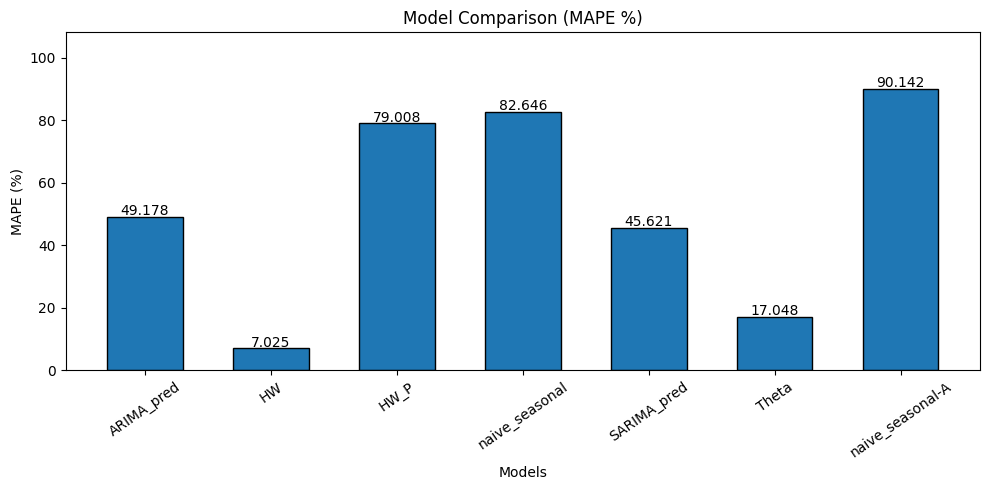

{'ARIMA_pred': np.float64(49.17810604607095),
 'HW': np.float64(7.025415163794967),
 'HW_P': np.float64(79.00842133914584),
 'naive_seasonal': np.float64(82.6457390543526),
 'SARIMA_pred': np.float64(45.62138333819736),
 'Theta': np.float64(17.048115882074036),
 'naive_seasonal-A': np.float64(90.14245765138641)}

In [ ]:
test['naive_seasonal'] = serie_6.iloc[-24:-12].values
columns = ['ARIMA_pred','HW','HW_P','naive_seasonal','SARIMA_pred','Theta','naive_seasonal-A']
plot_model_mape(test,'Values',columns)

In [ ]:
test

,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred,HW,HW_P,Theta
252,0.186094,0.444688,0.282264,0.159321,0.170935,0.165517,0.152823,0.173294
253,0.179685,0.412023,0.282264,0.143595,0.173996,0.159258,0.132349,0.172959
254,0.176004,0.375615,0.282264,0.130461,0.178110,0.154256,0.111874,0.170338
255,0.165046,0.341323,0.282264,0.116214,0.190802,0.150257,0.091399,0.172555
256,0.160674,0.292300,0.282264,0.103438,0.201172,0.147060,0.070925,0.170711
257,0.148492,0.262923,0.282264,0.088449,0.212692,0.144504,0.050450,0.170788
258,0.140049,0.246220,0.282264,0.074835,0.223138,0.142459,0.029975,0.174253
259,0.135862,0.234041,0.282264,0.059815,0.227119,0.140825,0.009501,0.171402
260,0.131318,0.220426,0.282264,0.046798,0.229877,0.139517,-0.010974,0.169474
261,0.133851,0.197167,0.282264,0.032377,0.237413,0.138471,-0.031449,0.168764


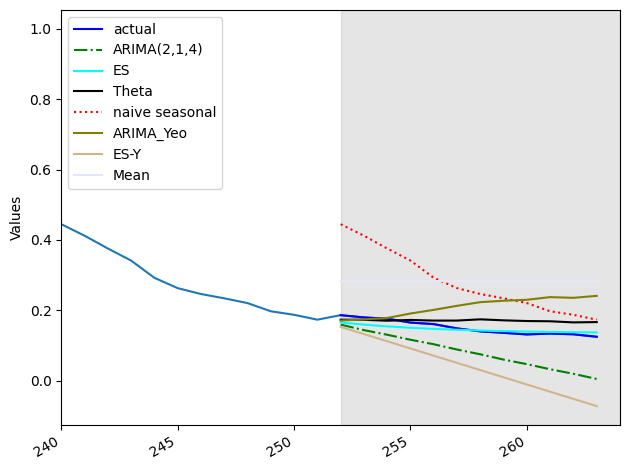

In [ ]:
fig, ax = plt.subplots()

ax.plot(serie_6)
ax.plot(test["Values"], 'b-', label='actual')
ax.plot(test['ARIMA_pred'], 'g-.', label='ARIMA(2,1,4)')
ax.plot(test['HW'], 'cyan', label='ES')
ax.plot(test['Theta'], 'black', label='Theta')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['SARIMA_pred'], 'olive', label='ARIMA_Yeo')
ax.plot(test['HW_P'], 'tan', label='ES-Y')
ax.plot(test['naive_seasonal-A'] , 'lavender', label='Mean')

ax.set_ylabel('Values')
ax.axvspan(252, 264, color='#808080', alpha=0.2)

ax.legend(loc=2)

ax.set_xlim(240, 264)

fig.autofmt_xdate()
plt.tight_layout()

## Métricas finais

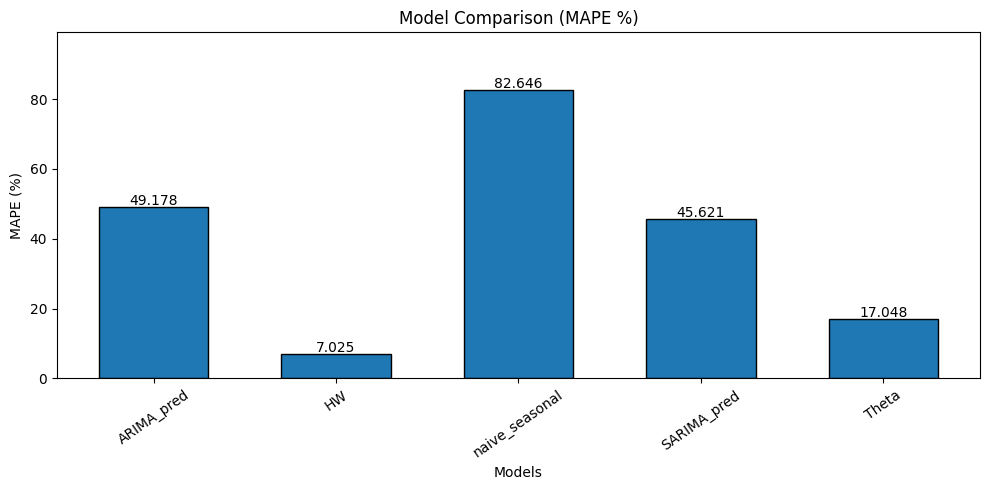

{'ARIMA_pred': np.float64(49.17810604607095),
 'HW': np.float64(7.025415163794967),
 'naive_seasonal': np.float64(82.6457390543526),
 'SARIMA_pred': np.float64(45.62138333819736),
 'Theta': np.float64(17.048115882074036)}

In [ ]:
columns = ['ARIMA_pred','HW','naive_seasonal','SARIMA_pred','Theta']
plot_model_mape(test,'Values',columns)

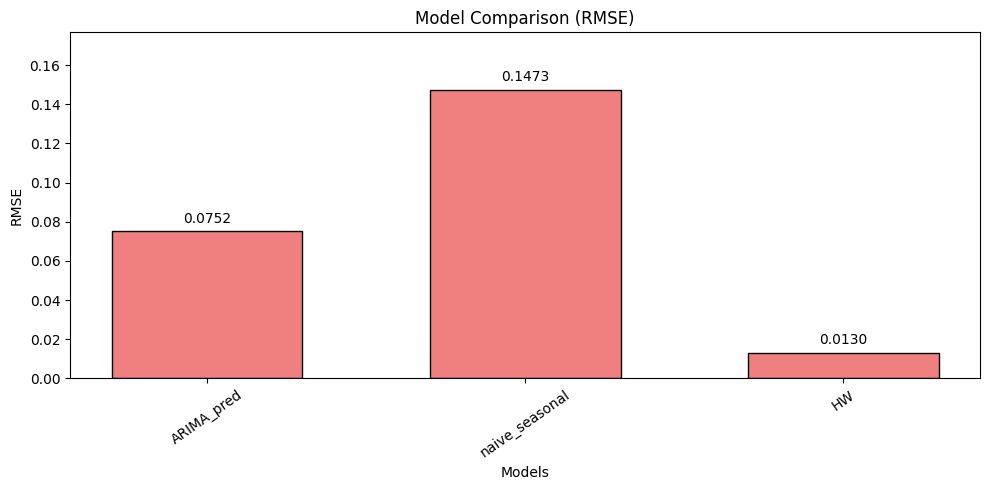

In [ ]:
columns_to_plot = ['ARIMA_pred','naive_seasonal','HW']

rmse_results = plot_model_rmse(test, 'Values', columns_to_plot)

# Previsão para a série (próximos 12 meses)

In [ ]:


pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(serie_6.values.reshape(-1, 1)).flatten(), index=serie_6.index)
ES = ExponentialSmoothing(train_transformed,trend='add', damped_trend=True)
ES_fit = ES.fit()
forecast =  pt.inverse_transform(ES_fit.forecast(12).values.reshape(-1, 1)).flatten()

forecast


array([0.12242236, 0.12045483, 0.11881059, 0.11743634, 0.11628763,
       0.11532734, 0.11452451, 0.11385328, 0.11329204, 0.11282275,
       0.11243033, 0.11210218])

In [ ]:
# ----- Salvando previsões numeradas em um .txt -----
horizon = len(forecast)
with open("6.csv", "w") as f:
    for i, value in enumerate(forecast, 1):
        f.write(f"{value:};\n")